# TP Coding a GAN in Pytorch

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore GANs applied to the mnist (and possibly cifar10) datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [69]:

import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

def pytorch_to_numpy(x):
  return x.detach().numpy()


# Decide which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"


## Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [70]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0]
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0]
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)



In [71]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

## GAN parameters

In [72]:

## GAN parameters
z_dim = 10
batch_size = 64
## parameters for training
n_epochs = 400
n_iters_inner=1	#number of internal loops
sample_interval=100
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

# hidden dimensions : careful, the order here is with respect to the generator, and the discriminator is in the opposite order
h_dim_1 = 256
h_dim_2 = 512

## Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

In [73]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    # START TO FILL IN
    self.fc1 = nn.Linear(self.z_dim, self.h_dim_1)
    self.fc2 = nn.Linear(self.h_dim_1, self.h_dim_2)
    self.fc3 = nn.Linear(self.h_dim_2, self.n_pixels * self.n_channels)
    self.leaky_relu = nn.LeakyReLU(0.2)
    self.tanh = nn.Tanh()
    # END TO FILL IN

  def forward(self, z):
    # START TO FILL IN
    h1 = self.leaky_relu(self.fc1(z))
    h2 = self.leaky_relu(self.fc2(h1))
    y = self.tanh(self.fc3(h2))
    y = y.view(-1, self.n_channels, self.n_rows, self.n_cols)
    # END TO FILL IN

    return(y)


In [74]:

class Discriminator(nn.Module):
  def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    # START TO FILL IN
    self.fc1 = nn.Linear(self.n_pixels * self.n_channels, self.h_dim_2)
    self.fc2 = nn.Linear(self.h_dim_2, self.h_dim_1)
    self.fc3 = nn.Linear(self.h_dim_1, 1)
    self.leaky_relu = nn.LeakyReLU(0.2)
    # END TO FILL IN

  def forward(self, x):
    x = x.view(-1, self.n_pixels * self.n_channels)

    # Forward pass through the discriminator network
    h1 = self.leaky_relu(self.fc1(x))
    h2 = self.leaky_relu(self.fc2(h1))
    y = torch.sigmoid(self.fc3(h2))  # FILL IN HERE
    return y




Create generator and discriminator

In [75]:
gen_model = Generator(z_dim=z_dim, h_dim_1=h_dim_1, h_dim_2=h_dim_2, n_rows=n_rows, n_cols=n_cols, n_channels=n_channels).to(device)
# Print the model
print(gen_model)

disc_model = Discriminator(h_dim_2=h_dim_2, h_dim_1=h_dim_1, z_dim=z_dim, n_rows=n_rows, n_cols=n_cols, n_channels=n_channels).to(device)
# Print the model
print(disc_model)

Generator(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (tanh): Tanh()
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
)


## Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-D(G(z))))$

You can use the ```torch.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop, ie. the number of epochs). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$



In [76]:

# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

# criterion used for the discriminator loss
bce_criterion = nn.BCELoss()  # FILL IN CODE

# criterion used for the generator loss
def loss_fn_gen(d_gen_data):
  loss_gen = torch.mean(torch.log(1 - d_gen_data))  # FILL IN CODE
  return loss_gen



### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

In [77]:

def sample_images(generator,z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device=device) #np.random.normal(0, 1, (r * c, z_dim))

  gen_imgs = np.transpose( generator(z_random).cpu().detach().numpy() , (0,2,3,1))

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        gen_imgs_temp = gen_imgs.copy()
        gen_imgs_temp = 255.*np.clip(gen_imgs_temp,0.0,1.0)
        axs[i,j].imshow(gen_imgs_temp[cnt, :,:,:].astype(np.uint8))
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

## Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n_{epochs}-1$
  - For $j=0$ to $n_{iters\_inner}-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$

You can use ```torch.randn``` to create a batch of random Gaussian latent codes:
- ```torch.randn(dim_1, dim_2, dim_3, device=device)```
where ```dim_1, dim_2, dim_3``` are the dimensions of the Tensor.

To create a batch of labels equal to 1, use the following function:
- ```torch.ones(my_shape, dtype=torch.float, device=device)```
where ```my_shape``` is the shape of the tensor of ones that you wish.

Similarly, to create a batch of zeros, use:
- ```torch.zeros(my_shape, dtype=torch.float, device=device)```

In [78]:
print(device)

cuda:0


Starting Training
[0/400][0/16] 	Loss_D: 1.4063	Loss_G: -0.7028	D(x): 0.4947	D(G(z)): 0.5044


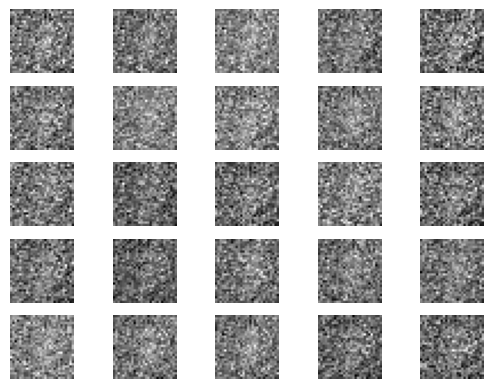

[1/400][0/16] 	Loss_D: 0.8675	Loss_G: -0.7881	D(x): 0.9497	D(G(z)): 0.5576
[2/400][0/16] 	Loss_D: 1.0898	Loss_G: -0.9161	D(x): 0.8537	D(G(z)): 0.6058
[3/400][0/16] 	Loss_D: 1.0185	Loss_G: -0.7413	D(x): 0.7968	D(G(z)): 0.5462
[4/400][0/16] 	Loss_D: 1.2263	Loss_G: -0.5870	D(x): 0.8143	D(G(z)): 0.6385
[5/400][0/16] 	Loss_D: 1.6758	Loss_G: -0.8526	D(x): 0.5351	D(G(z)): 0.6445
[6/400][0/16] 	Loss_D: 1.0497	Loss_G: -0.3727	D(x): 0.7923	D(G(z)): 0.5535
[7/400][0/16] 	Loss_D: 0.9569	Loss_G: -0.5181	D(x): 0.7073	D(G(z)): 0.4541
[8/400][0/16] 	Loss_D: 1.2436	Loss_G: -0.7004	D(x): 0.6180	D(G(z)): 0.5300
[9/400][0/16] 	Loss_D: 0.9507	Loss_G: -1.1863	D(x): 0.7847	D(G(z)): 0.5044
[10/400][0/16] 	Loss_D: 0.6192	Loss_G: -0.2440	D(x): 0.7231	D(G(z)): 0.2505
[11/400][0/16] 	Loss_D: 0.9817	Loss_G: -0.4371	D(x): 0.6697	D(G(z)): 0.4382
[12/400][0/16] 	Loss_D: 0.7582	Loss_G: -0.6447	D(x): 0.7072	D(G(z)): 0.3309
[13/400][0/16] 	Loss_D: 0.7247	Loss_G: -0.4972	D(x): 0.6785	D(G(z)): 0.2704
[14/400][0/16] 	Loss_

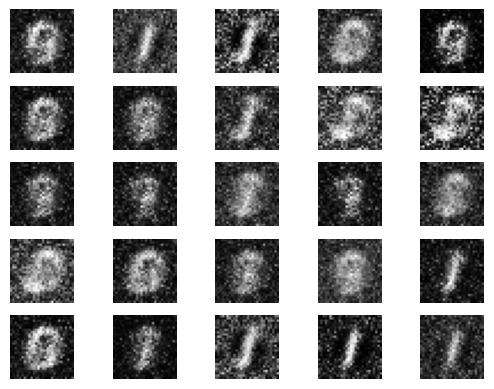

[26/400][0/16] 	Loss_D: 0.5713	Loss_G: -0.1450	D(x): 0.7804	D(G(z)): 0.2563
[27/400][0/16] 	Loss_D: 0.5306	Loss_G: -0.4580	D(x): 0.8394	D(G(z)): 0.2842
[28/400][0/16] 	Loss_D: 0.6129	Loss_G: -0.0819	D(x): 0.7296	D(G(z)): 0.2082
[29/400][0/16] 	Loss_D: 1.1360	Loss_G: -0.5425	D(x): 0.8887	D(G(z)): 0.6280
[30/400][0/16] 	Loss_D: 0.4537	Loss_G: -0.8715	D(x): 0.7758	D(G(z)): 0.1520
[31/400][0/16] 	Loss_D: 0.9323	Loss_G: -0.0367	D(x): 0.8840	D(G(z)): 0.5210
[32/400][0/16] 	Loss_D: 0.3877	Loss_G: -0.1745	D(x): 0.8305	D(G(z)): 0.1646
[33/400][0/16] 	Loss_D: 0.2175	Loss_G: -0.0555	D(x): 0.8872	D(G(z)): 0.0838
[34/400][0/16] 	Loss_D: 1.0455	Loss_G: -0.2525	D(x): 0.8065	D(G(z)): 0.4780
[35/400][0/16] 	Loss_D: 0.6247	Loss_G: -0.2041	D(x): 0.6201	D(G(z)): 0.0470
[36/400][0/16] 	Loss_D: 0.4955	Loss_G: -0.0974	D(x): 0.8903	D(G(z)): 0.3050
[37/400][0/16] 	Loss_D: 0.9881	Loss_G: -0.2255	D(x): 0.9293	D(G(z)): 0.5920
[38/400][0/16] 	Loss_D: 0.2704	Loss_G: -0.5571	D(x): 0.8426	D(G(z)): 0.0333
[39/400][0/1

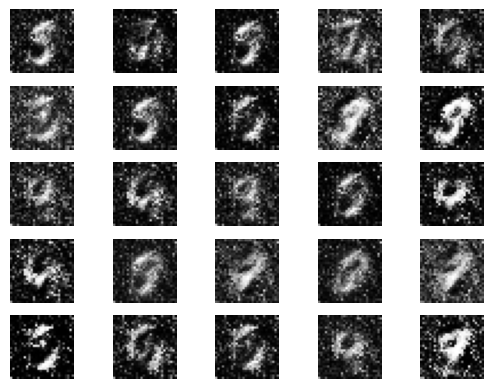

[51/400][0/16] 	Loss_D: 1.3154	Loss_G: -0.0569	D(x): 0.9599	D(G(z)): 0.5955
[52/400][0/16] 	Loss_D: 0.5863	Loss_G: -0.7905	D(x): 0.9314	D(G(z)): 0.3380
[53/400][0/16] 	Loss_D: 0.4133	Loss_G: -0.2893	D(x): 0.8029	D(G(z)): 0.1487
[54/400][0/16] 	Loss_D: 0.3065	Loss_G: -0.3282	D(x): 0.8979	D(G(z)): 0.1599
[55/400][0/16] 	Loss_D: 0.4322	Loss_G: -0.1682	D(x): 0.8035	D(G(z)): 0.1476
[56/400][0/16] 	Loss_D: 0.4904	Loss_G: -0.2820	D(x): 0.8911	D(G(z)): 0.2871
[57/400][0/16] 	Loss_D: 0.9158	Loss_G: -0.0348	D(x): 0.9526	D(G(z)): 0.4268
[58/400][0/16] 	Loss_D: 0.3046	Loss_G: -0.1056	D(x): 0.8281	D(G(z)): 0.0889
[59/400][0/16] 	Loss_D: 0.2882	Loss_G: -0.2731	D(x): 0.8975	D(G(z)): 0.1586
[60/400][0/16] 	Loss_D: 2.1452	Loss_G: -0.0907	D(x): 0.2444	D(G(z)): 0.0140
[61/400][0/16] 	Loss_D: 0.6131	Loss_G: -0.5848	D(x): 0.6351	D(G(z)): 0.0435
[62/400][0/16] 	Loss_D: 0.5514	Loss_G: -0.6705	D(x): 0.8997	D(G(z)): 0.3514
[63/400][0/16] 	Loss_D: 1.4597	Loss_G: -0.1844	D(x): 0.3134	D(G(z)): 0.0243
[64/400][0/1

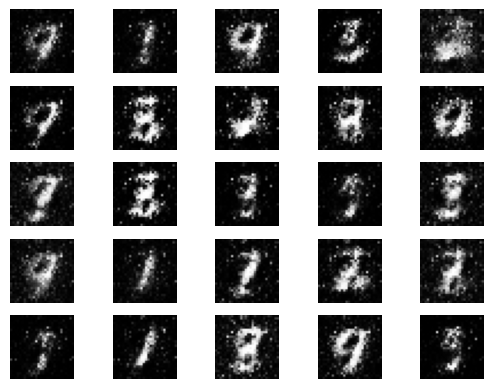

[76/400][0/16] 	Loss_D: 3.2935	Loss_G: -0.1094	D(x): 0.1239	D(G(z)): 0.0021
[77/400][0/16] 	Loss_D: 0.9317	Loss_G: -0.1506	D(x): 0.6368	D(G(z)): 0.2236
[78/400][0/16] 	Loss_D: 0.7296	Loss_G: -0.1342	D(x): 0.8015	D(G(z)): 0.3766
[79/400][0/16] 	Loss_D: 0.3830	Loss_G: -0.0366	D(x): 0.8003	D(G(z)): 0.0942
[80/400][0/16] 	Loss_D: 0.5235	Loss_G: -0.0412	D(x): 0.9202	D(G(z)): 0.3469
[81/400][0/16] 	Loss_D: 0.4262	Loss_G: -0.5640	D(x): 0.7263	D(G(z)): 0.0324
[82/400][0/16] 	Loss_D: 1.2680	Loss_G: -0.0290	D(x): 0.6629	D(G(z)): 0.5333
[83/400][0/16] 	Loss_D: 0.3894	Loss_G: -0.1783	D(x): 0.8120	D(G(z)): 0.1164
[84/400][0/16] 	Loss_D: 0.4749	Loss_G: -0.2734	D(x): 0.9001	D(G(z)): 0.2908
[85/400][0/16] 	Loss_D: 1.7070	Loss_G: -0.2524	D(x): 0.5143	D(G(z)): 0.4242
[86/400][0/16] 	Loss_D: 1.2243	Loss_G: -0.0582	D(x): 0.8468	D(G(z)): 0.5134
[87/400][0/16] 	Loss_D: 1.5717	Loss_G: -0.2195	D(x): 0.8858	D(G(z)): 0.5309
[88/400][0/16] 	Loss_D: 0.4212	Loss_G: -0.1623	D(x): 0.8334	D(G(z)): 0.1925
[89/400][0/1

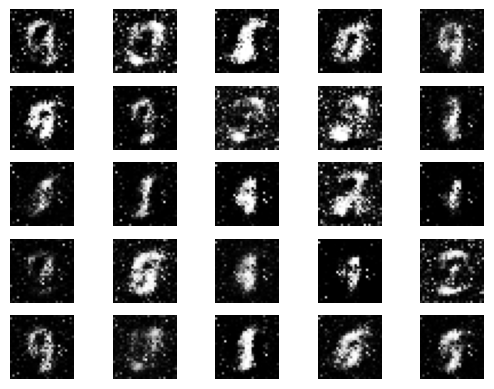

[101/400][0/16] 	Loss_D: 0.6077	Loss_G: -0.0749	D(x): 0.7221	D(G(z)): 0.1523
[102/400][0/16] 	Loss_D: 0.2694	Loss_G: -0.2112	D(x): 0.8915	D(G(z)): 0.1219
[103/400][0/16] 	Loss_D: 1.0495	Loss_G: -0.5628	D(x): 0.9238	D(G(z)): 0.4887
[104/400][0/16] 	Loss_D: 0.6414	Loss_G: -0.4616	D(x): 0.8377	D(G(z)): 0.2913
[105/400][0/16] 	Loss_D: 0.3786	Loss_G: -0.2451	D(x): 0.7807	D(G(z)): 0.0613
[106/400][0/16] 	Loss_D: 0.2741	Loss_G: -0.6396	D(x): 0.8262	D(G(z)): 0.0590
[107/400][0/16] 	Loss_D: 0.3482	Loss_G: -0.2318	D(x): 0.8331	D(G(z)): 0.1265
[108/400][0/16] 	Loss_D: 0.5625	Loss_G: -0.0479	D(x): 0.8414	D(G(z)): 0.2924
[109/400][0/16] 	Loss_D: 0.7347	Loss_G: -0.3133	D(x): 0.6316	D(G(z)): 0.0334
[110/400][0/16] 	Loss_D: 1.4405	Loss_G: -0.0330	D(x): 0.7266	D(G(z)): 0.4395
[111/400][0/16] 	Loss_D: 0.3565	Loss_G: -0.1557	D(x): 0.7786	D(G(z)): 0.0357
[112/400][0/16] 	Loss_D: 0.2340	Loss_G: -0.0291	D(x): 0.9629	D(G(z)): 0.1628
[113/400][0/16] 	Loss_D: 0.2879	Loss_G: -0.6804	D(x): 0.8188	D(G(z)): 0.0245

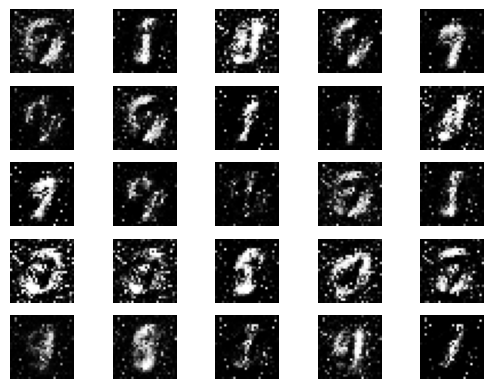

[126/400][0/16] 	Loss_D: 0.4003	Loss_G: -0.1477	D(x): 0.8516	D(G(z)): 0.1772
[127/400][0/16] 	Loss_D: 0.8295	Loss_G: -0.2995	D(x): 0.5945	D(G(z)): 0.0064
[128/400][0/16] 	Loss_D: 0.2244	Loss_G: -0.2252	D(x): 0.8623	D(G(z)): 0.0415
[129/400][0/16] 	Loss_D: 1.8713	Loss_G: -0.0108	D(x): 0.3527	D(G(z)): 0.0115
[130/400][0/16] 	Loss_D: 1.0000	Loss_G: -0.2188	D(x): 0.8248	D(G(z)): 0.5246
[131/400][0/16] 	Loss_D: 0.4998	Loss_G: -0.6299	D(x): 0.7892	D(G(z)): 0.1978
[132/400][0/16] 	Loss_D: 0.1805	Loss_G: -0.3965	D(x): 0.8619	D(G(z)): 0.0122
[133/400][0/16] 	Loss_D: 0.4189	Loss_G: -0.1155	D(x): 0.8831	D(G(z)): 0.2276
[134/400][0/16] 	Loss_D: 0.2128	Loss_G: -0.5452	D(x): 0.9614	D(G(z)): 0.1550
[135/400][0/16] 	Loss_D: 0.0647	Loss_G: -0.1522	D(x): 0.9510	D(G(z)): 0.0112
[136/400][0/16] 	Loss_D: 0.6015	Loss_G: -0.0630	D(x): 0.6800	D(G(z)): 0.0162
[137/400][0/16] 	Loss_D: 0.2458	Loss_G: -0.1450	D(x): 0.9600	D(G(z)): 0.1832
[138/400][0/16] 	Loss_D: 0.1368	Loss_G: -0.1638	D(x): 0.9194	D(G(z)): 0.0448

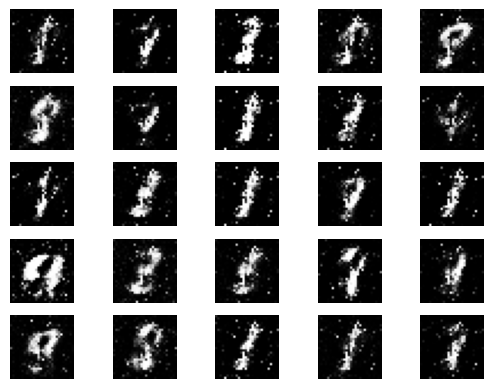

[151/400][0/16] 	Loss_D: 0.2108	Loss_G: -0.1754	D(x): 0.8843	D(G(z)): 0.0593
[152/400][0/16] 	Loss_D: 0.4505	Loss_G: -0.0559	D(x): 0.9712	D(G(z)): 0.3119
[153/400][0/16] 	Loss_D: 0.1418	Loss_G: -0.0274	D(x): 0.9362	D(G(z)): 0.0566
[154/400][0/16] 	Loss_D: 0.6530	Loss_G: -0.2791	D(x): 0.7000	D(G(z)): 0.0263
[155/400][0/16] 	Loss_D: 0.4021	Loss_G: -1.3478	D(x): 0.7876	D(G(z)): 0.0821
[156/400][0/16] 	Loss_D: 0.3294	Loss_G: -0.0447	D(x): 0.9352	D(G(z)): 0.2220
[157/400][0/16] 	Loss_D: 0.1515	Loss_G: -0.1535	D(x): 0.9112	D(G(z)): 0.0452
[158/400][0/16] 	Loss_D: 0.7370	Loss_G: -0.1306	D(x): 0.8870	D(G(z)): 0.4058
[159/400][0/16] 	Loss_D: 0.3554	Loss_G: -0.2056	D(x): 0.9538	D(G(z)): 0.2418
[160/400][0/16] 	Loss_D: 0.7062	Loss_G: -0.0159	D(x): 0.6627	D(G(z)): 0.0205
[161/400][0/16] 	Loss_D: 0.6816	Loss_G: -0.0111	D(x): 0.6568	D(G(z)): 0.0208
[162/400][0/16] 	Loss_D: 0.1543	Loss_G: -0.1627	D(x): 0.9383	D(G(z)): 0.0787
[163/400][0/16] 	Loss_D: 0.1432	Loss_G: -0.0194	D(x): 0.9178	D(G(z)): 0.0377

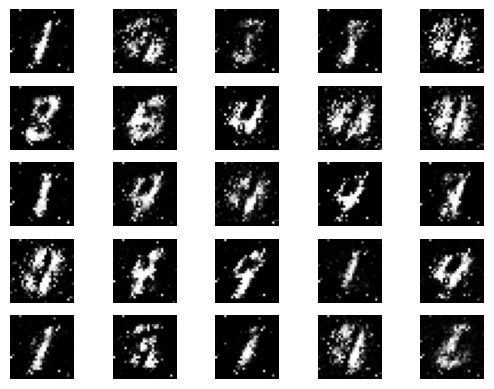

[176/400][0/16] 	Loss_D: 0.4045	Loss_G: -0.4859	D(x): 0.8884	D(G(z)): 0.2012
[177/400][0/16] 	Loss_D: 1.8786	Loss_G: -0.0316	D(x): 0.4603	D(G(z)): 0.0035
[178/400][0/16] 	Loss_D: 0.1588	Loss_G: -0.0210	D(x): 0.9112	D(G(z)): 0.0506
[179/400][0/16] 	Loss_D: 0.3201	Loss_G: -0.0805	D(x): 0.8506	D(G(z)): 0.0978
[180/400][0/16] 	Loss_D: 0.1628	Loss_G: -0.3934	D(x): 0.9231	D(G(z)): 0.0557
[181/400][0/16] 	Loss_D: 0.5206	Loss_G: -0.0426	D(x): 0.7160	D(G(z)): 0.0182
[182/400][0/16] 	Loss_D: 0.6403	Loss_G: -0.0078	D(x): 0.8506	D(G(z)): 0.2914
[183/400][0/16] 	Loss_D: 0.5457	Loss_G: -0.0216	D(x): 0.7377	D(G(z)): 0.0293
[184/400][0/16] 	Loss_D: 2.2499	Loss_G: -0.4295	D(x): 0.9309	D(G(z)): 0.7024
[185/400][0/16] 	Loss_D: 0.5459	Loss_G: -0.0261	D(x): 0.7988	D(G(z)): 0.2168
[186/400][0/16] 	Loss_D: 0.4292	Loss_G: -0.3872	D(x): 0.8445	D(G(z)): 0.2043
[187/400][0/16] 	Loss_D: 0.4800	Loss_G: -0.8667	D(x): 0.7922	D(G(z)): 0.1435
[188/400][0/16] 	Loss_D: 0.3097	Loss_G: -0.4570	D(x): 0.8318	D(G(z)): 0.0730

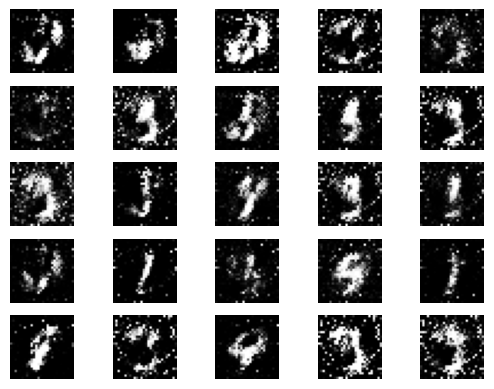

[201/400][0/16] 	Loss_D: 0.6270	Loss_G: -0.0328	D(x): 0.6804	D(G(z)): 0.0095
[202/400][0/16] 	Loss_D: 0.6494	Loss_G: -0.5284	D(x): 0.9435	D(G(z)): 0.4258
[203/400][0/16] 	Loss_D: 0.2235	Loss_G: -0.2120	D(x): 0.9102	D(G(z)): 0.1040
[204/400][0/16] 	Loss_D: 0.9862	Loss_G: -0.0351	D(x): 0.5311	D(G(z)): 0.0210
[205/400][0/16] 	Loss_D: 0.4122	Loss_G: -0.0788	D(x): 0.7610	D(G(z)): 0.0526
[206/400][0/16] 	Loss_D: 0.8665	Loss_G: -0.0739	D(x): 0.5848	D(G(z)): 0.0846
[207/400][0/16] 	Loss_D: 0.5430	Loss_G: -0.0700	D(x): 0.8183	D(G(z)): 0.2622
[208/400][0/16] 	Loss_D: 0.6461	Loss_G: -0.0259	D(x): 0.8578	D(G(z)): 0.3606
[209/400][0/16] 	Loss_D: 0.5444	Loss_G: -0.6878	D(x): 0.7297	D(G(z)): 0.1351
[210/400][0/16] 	Loss_D: 0.8041	Loss_G: -0.2833	D(x): 0.5906	D(G(z)): 0.0272
[211/400][0/16] 	Loss_D: 0.2154	Loss_G: -0.0811	D(x): 0.9242	D(G(z)): 0.1214
[212/400][0/16] 	Loss_D: 0.1465	Loss_G: -0.0392	D(x): 0.8894	D(G(z)): 0.0105
[213/400][0/16] 	Loss_D: 0.5430	Loss_G: -0.0411	D(x): 0.7580	D(G(z)): 0.1872

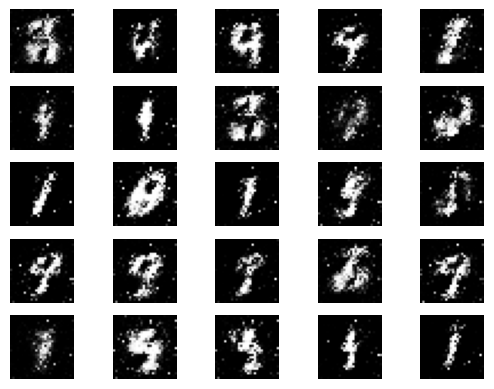

[226/400][0/16] 	Loss_D: 0.3330	Loss_G: -0.0013	D(x): 0.9532	D(G(z)): 0.2168
[227/400][0/16] 	Loss_D: 0.2954	Loss_G: -0.0012	D(x): 0.9697	D(G(z)): 0.2268
[228/400][0/16] 	Loss_D: 0.3832	Loss_G: -0.0374	D(x): 0.7891	D(G(z)): 0.0121
[229/400][0/16] 	Loss_D: 1.5554	Loss_G: -0.0235	D(x): 0.9464	D(G(z)): 0.4981
[230/400][0/16] 	Loss_D: 0.3515	Loss_G: -0.2080	D(x): 0.9284	D(G(z)): 0.2106
[231/400][0/16] 	Loss_D: 0.9487	Loss_G: -0.2350	D(x): 0.5568	D(G(z)): 0.0220
[232/400][0/16] 	Loss_D: 0.5294	Loss_G: -0.0385	D(x): 0.9210	D(G(z)): 0.3388
[233/400][0/16] 	Loss_D: 0.1904	Loss_G: -0.1522	D(x): 0.8657	D(G(z)): 0.0181
[234/400][0/16] 	Loss_D: 0.3861	Loss_G: -0.0177	D(x): 0.9372	D(G(z)): 0.2548
[235/400][0/16] 	Loss_D: 0.1598	Loss_G: -0.9549	D(x): 0.9194	D(G(z)): 0.0485
[236/400][0/16] 	Loss_D: 0.0768	Loss_G: -0.6024	D(x): 0.9825	D(G(z)): 0.0548
[237/400][0/16] 	Loss_D: 0.1748	Loss_G: -0.0736	D(x): 0.9698	D(G(z)): 0.1244
[238/400][0/16] 	Loss_D: 0.5284	Loss_G: -0.0225	D(x): 0.7622	D(G(z)): 0.0929

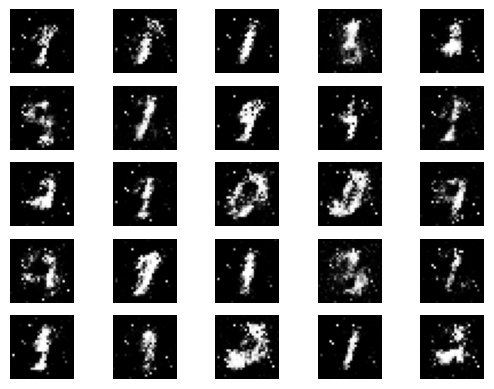

[251/400][0/16] 	Loss_D: 0.6199	Loss_G: -0.1624	D(x): 0.7513	D(G(z)): 0.1353
[252/400][0/16] 	Loss_D: 0.7156	Loss_G: -0.7385	D(x): 0.7691	D(G(z)): 0.2115
[253/400][0/16] 	Loss_D: 0.3766	Loss_G: -0.2465	D(x): 0.8652	D(G(z)): 0.1648
[254/400][0/16] 	Loss_D: 0.1831	Loss_G: -0.0205	D(x): 0.9499	D(G(z)): 0.1119
[255/400][0/16] 	Loss_D: 0.4249	Loss_G: -0.0790	D(x): 0.8741	D(G(z)): 0.2020
[256/400][0/16] 	Loss_D: 0.2029	Loss_G: -0.8839	D(x): 0.9810	D(G(z)): 0.1592
[257/400][0/16] 	Loss_D: 1.2486	Loss_G: -0.0072	D(x): 0.9007	D(G(z)): 0.4847
[258/400][0/16] 	Loss_D: 0.6896	Loss_G: -0.0096	D(x): 0.9652	D(G(z)): 0.4306
[259/400][0/16] 	Loss_D: 0.2566	Loss_G: -0.0867	D(x): 0.9552	D(G(z)): 0.1802
[260/400][0/16] 	Loss_D: 0.1706	Loss_G: -0.0527	D(x): 0.9300	D(G(z)): 0.0780
[261/400][0/16] 	Loss_D: 0.4252	Loss_G: -0.0008	D(x): 0.7874	D(G(z)): 0.0052
[262/400][0/16] 	Loss_D: 0.1215	Loss_G: -0.0525	D(x): 0.9778	D(G(z)): 0.0915
[263/400][0/16] 	Loss_D: 0.0770	Loss_G: -0.0762	D(x): 0.9541	D(G(z)): 0.0248

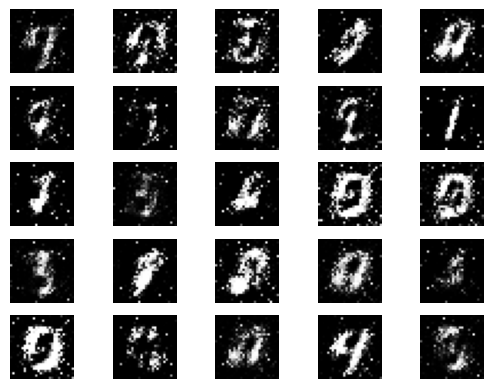

[276/400][0/16] 	Loss_D: 0.1999	Loss_G: -0.0313	D(x): 0.9679	D(G(z)): 0.1416
[277/400][0/16] 	Loss_D: 0.1286	Loss_G: -0.0010	D(x): 0.9005	D(G(z)): 0.0076
[278/400][0/16] 	Loss_D: 0.1570	Loss_G: -0.0005	D(x): 0.9473	D(G(z)): 0.0917
[279/400][0/16] 	Loss_D: 0.1523	Loss_G: -0.0920	D(x): 0.9140	D(G(z)): 0.0430
[280/400][0/16] 	Loss_D: 0.1800	Loss_G: -0.0394	D(x): 0.8736	D(G(z)): 0.0137
[281/400][0/16] 	Loss_D: 0.0833	Loss_G: -0.0312	D(x): 0.9522	D(G(z)): 0.0240
[282/400][0/16] 	Loss_D: 0.1492	Loss_G: -0.9758	D(x): 0.8992	D(G(z)): 0.0017
[283/400][0/16] 	Loss_D: 0.3711	Loss_G: -0.0150	D(x): 0.9120	D(G(z)): 0.2156
[284/400][0/16] 	Loss_D: 0.9222	Loss_G: -0.0975	D(x): 0.9103	D(G(z)): 0.5248
[285/400][0/16] 	Loss_D: 0.1917	Loss_G: -0.8553	D(x): 0.9681	D(G(z)): 0.1394
[286/400][0/16] 	Loss_D: 0.3162	Loss_G: -0.0921	D(x): 0.9035	D(G(z)): 0.1670
[287/400][0/16] 	Loss_D: 0.6263	Loss_G: -0.0039	D(x): 0.9616	D(G(z)): 0.4366
[288/400][0/16] 	Loss_D: 0.1912	Loss_G: -0.0288	D(x): 0.9582	D(G(z)): 0.1320

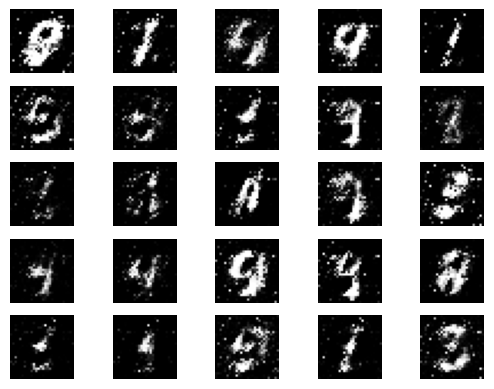

[301/400][0/16] 	Loss_D: 0.2636	Loss_G: -0.0024	D(x): 0.8571	D(G(z)): 0.0031
[302/400][0/16] 	Loss_D: 0.0676	Loss_G: -0.0308	D(x): 0.9645	D(G(z)): 0.0257
[303/400][0/16] 	Loss_D: 0.0834	Loss_G: -0.0621	D(x): 0.9468	D(G(z)): 0.0120
[304/400][0/16] 	Loss_D: 0.1074	Loss_G: -0.0057	D(x): 0.9747	D(G(z)): 0.0710
[305/400][0/16] 	Loss_D: 0.0996	Loss_G: -0.0864	D(x): 0.9413	D(G(z)): 0.0196
[306/400][0/16] 	Loss_D: 0.3224	Loss_G: -0.0031	D(x): 0.7878	D(G(z)): 0.0058
[307/400][0/16] 	Loss_D: 0.1215	Loss_G: -0.0297	D(x): 0.9309	D(G(z)): 0.0347
[308/400][0/16] 	Loss_D: 0.0711	Loss_G: -0.0020	D(x): 0.9485	D(G(z)): 0.0072
[309/400][0/16] 	Loss_D: 0.2728	Loss_G: -0.0364	D(x): 0.9285	D(G(z)): 0.1554
[310/400][0/16] 	Loss_D: 0.2421	Loss_G: -0.2072	D(x): 0.9543	D(G(z)): 0.1629
[311/400][0/16] 	Loss_D: 3.1099	Loss_G: -0.0034	D(x): 0.9731	D(G(z)): 0.9370
[312/400][0/16] 	Loss_D: 0.1456	Loss_G: -0.2253	D(x): 0.9269	D(G(z)): 0.0587
[313/400][0/16] 	Loss_D: 0.1316	Loss_G: -0.0451	D(x): 0.9033	D(G(z)): 0.0056

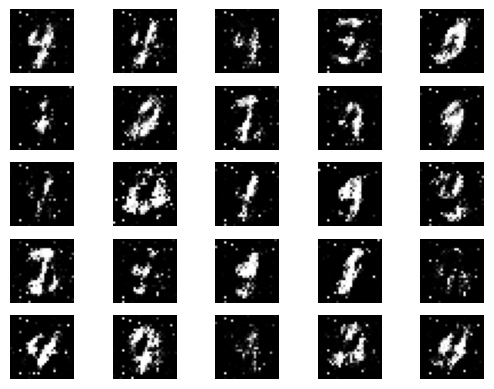

[326/400][0/16] 	Loss_D: 0.0804	Loss_G: -0.2933	D(x): 0.9688	D(G(z)): 0.0377
[327/400][0/16] 	Loss_D: 0.1101	Loss_G: -0.0292	D(x): 0.9332	D(G(z)): 0.0239
[328/400][0/16] 	Loss_D: 2.6261	Loss_G: -0.0026	D(x): 0.8385	D(G(z)): 0.8250
[329/400][0/16] 	Loss_D: 0.5410	Loss_G: -0.0066	D(x): 0.7411	D(G(z)): 0.0078
[330/400][0/16] 	Loss_D: 0.2573	Loss_G: -0.9346	D(x): 0.8846	D(G(z)): 0.0589
[331/400][0/16] 	Loss_D: 1.6247	Loss_G: -0.0513	D(x): 0.8844	D(G(z)): 0.5047
[332/400][0/16] 	Loss_D: 0.4542	Loss_G: -0.0096	D(x): 0.9224	D(G(z)): 0.2948
[333/400][0/16] 	Loss_D: 0.0751	Loss_G: -0.1371	D(x): 0.9749	D(G(z)): 0.0453
[334/400][0/16] 	Loss_D: 0.1845	Loss_G: -0.0128	D(x): 0.9099	D(G(z)): 0.0561
[335/400][0/16] 	Loss_D: 0.2046	Loss_G: -0.0383	D(x): 0.9821	D(G(z)): 0.1583
[336/400][0/16] 	Loss_D: 0.1356	Loss_G: -0.0517	D(x): 0.9822	D(G(z)): 0.1099
[337/400][0/16] 	Loss_D: 0.0957	Loss_G: -0.0032	D(x): 0.9304	D(G(z)): 0.0099
[338/400][0/16] 	Loss_D: 0.1735	Loss_G: -0.0754	D(x): 0.9645	D(G(z)): 0.1073

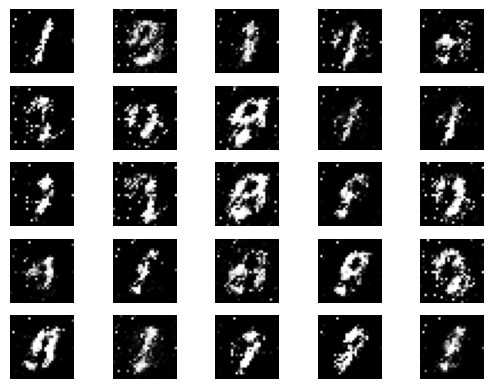

[351/400][0/16] 	Loss_D: 0.1362	Loss_G: -0.0017	D(x): 0.9476	D(G(z)): 0.0700
[352/400][0/16] 	Loss_D: 0.0550	Loss_G: -0.0013	D(x): 0.9638	D(G(z)): 0.0039
[353/400][0/16] 	Loss_D: 0.0481	Loss_G: -0.0519	D(x): 0.9676	D(G(z)): 0.0118
[354/400][0/16] 	Loss_D: 0.0476	Loss_G: -0.2019	D(x): 0.9682	D(G(z)): 0.0132
[355/400][0/16] 	Loss_D: 0.0681	Loss_G: -0.0107	D(x): 0.9780	D(G(z)): 0.0425
[356/400][0/16] 	Loss_D: 0.0196	Loss_G: -0.0401	D(x): 0.9885	D(G(z)): 0.0076
[357/400][0/16] 	Loss_D: 0.0307	Loss_G: -0.1683	D(x): 0.9777	D(G(z)): 0.0030
[358/400][0/16] 	Loss_D: 0.0938	Loss_G: -0.2533	D(x): 0.9406	D(G(z)): 0.0190
[359/400][0/16] 	Loss_D: 0.1401	Loss_G: -1.5423	D(x): 0.9477	D(G(z)): 0.0658
[360/400][0/16] 	Loss_D: 0.2338	Loss_G: -0.0494	D(x): 0.8930	D(G(z)): 0.0782
[361/400][0/16] 	Loss_D: 0.1132	Loss_G: -0.1064	D(x): 0.9512	D(G(z)): 0.0518
[362/400][0/16] 	Loss_D: 0.1459	Loss_G: -0.1574	D(x): 0.9723	D(G(z)): 0.1041
[363/400][0/16] 	Loss_D: 0.6418	Loss_G: -0.9960	D(x): 0.6953	D(G(z)): 0.0144

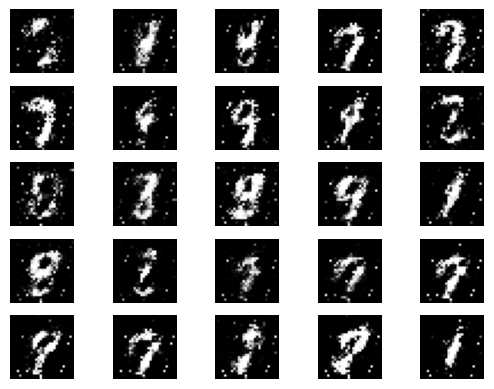

[376/400][0/16] 	Loss_D: 0.4191	Loss_G: -0.0067	D(x): 0.7806	D(G(z)): 0.0064
[377/400][0/16] 	Loss_D: 0.3284	Loss_G: -0.0438	D(x): 0.8242	D(G(z)): 0.0400
[378/400][0/16] 	Loss_D: 0.4945	Loss_G: -0.0688	D(x): 0.7700	D(G(z)): 0.0007
[379/400][0/16] 	Loss_D: 0.1343	Loss_G: -0.1820	D(x): 0.9303	D(G(z)): 0.0296
[380/400][0/16] 	Loss_D: 0.4449	Loss_G: -0.0191	D(x): 0.8640	D(G(z)): 0.1863
[381/400][0/16] 	Loss_D: 0.1520	Loss_G: -0.0648	D(x): 0.9282	D(G(z)): 0.0542
[382/400][0/16] 	Loss_D: 0.2656	Loss_G: -2.1807	D(x): 0.8491	D(G(z)): 0.0302
[383/400][0/16] 	Loss_D: 0.4100	Loss_G: -0.0192	D(x): 0.8264	D(G(z)): 0.0670
[384/400][0/16] 	Loss_D: 0.1405	Loss_G: -0.0276	D(x): 0.9226	D(G(z)): 0.0324
[385/400][0/16] 	Loss_D: 0.0966	Loss_G: -1.0147	D(x): 0.9332	D(G(z)): 0.0017
[386/400][0/16] 	Loss_D: 0.7592	Loss_G: -0.0760	D(x): 0.8523	D(G(z)): 0.3473
[387/400][0/16] 	Loss_D: 0.2403	Loss_G: -0.0275	D(x): 0.8641	D(G(z)): 0.0044
[388/400][0/16] 	Loss_D: 0.5043	Loss_G: -0.0080	D(x): 0.7517	D(G(z)): 0.0116

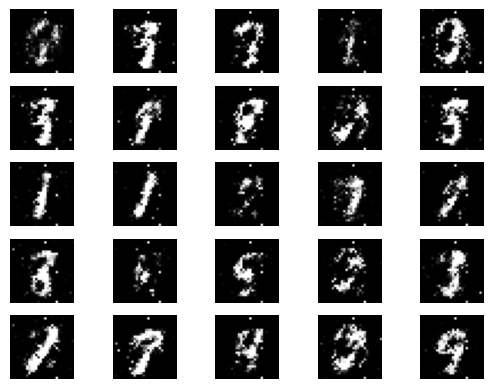

In [79]:

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []


sample_interval=25

print("Starting Training")
# For each epoch
for epoch in range(n_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(mnist_train_loader, 0):
    for iter_inner in range(0,n_iters_inner):

      ############################
      ### Train discriminator
      ############################
      ## Train with true data batch
      disc_model.zero_grad()
      # create true data and labels
      true_imgs = data[0].to(device)
      true_labels = torch.ones(len(true_imgs), dtype=torch.float, device=device)# FILL IN HERE. CAREFUL, WE WANT A 1-DIMENSIONAL TENSOR OF LABELS (DUE TO THE "VIEW" IN NEXT LINE)
      # put true data through discriminator
      d_output_true = disc_model(true_imgs).view(-1) # FILL IN HERE
      # bce loss on true data
      d_loss_true = bce_criterion(d_output_true, true_labels) # FILL IN HERE
      # backpropagation for discriminator, true loss
      d_loss_true.backward()
      disc_true_value = d_output_true.mean().item()

      ## Train with fake data batch
      # create fake data and labels
      # generate batch of random latent vectors
      z_latent_noise = torch.randn(len(data), 1, z_dim, dtype=torch.float, device=device) # FILL IN HERE
      # Generate batch of fake images
      fake_imgs = gen_model(z_latent_noise)  # FILL IN HERE
      fake_labels = torch.zeros(len(fake_imgs), dtype=torch.float, device=device)# FILL IN HERE
      # put fake data through discriminator
      disc_output_fake = disc_model(fake_imgs.detach()).view(-1)
      # bce loss on fake data
      disc_loss_fake = bce_criterion(disc_output_fake, fake_labels)
      # backpropagation for discriminator, fake loss
      disc_loss_fake.backward()
      disc_fake_value = disc_output_fake.mean().item()
      # Update discriminator
      optimizer_disc.step()

      d_loss_total = d_loss_true+disc_loss_fake

    ############################
    ### Train generator
    ############################
    gen_model.zero_grad()
    # We have updated the discriminator, so we need to update the output of the discriminator
    disc_gen_output_fake = disc_model(gen_model(torch.randn(len(data), 1, z_dim, dtype=torch.float, device=device))).view(-1) # FILL IN HERE
    # Generator loss, using the custom loss
    g_loss = loss_fn_gen(disc_gen_output_fake) # FILL IN HERE
    # backpropagation for generator
    g_loss.backward()
    #D_G_z2 = output.mean().item()
    # Update generator
    optimizer_gen.step()

    # Output training stats
    if i % 200 == 0:
      print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
      % (epoch, n_epochs, i, len(mnist_train_loader),d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value ))

    # Save Losses for plotting later
    G_losses.append(g_loss.item())
    D_losses.append(d_loss_total.item())


  if(epoch % sample_interval == 0):
    sample_images(gen_model,z_dim, rand_seed=30)

# end samples
sample_images(gen_model,z_dim, rand_seed=30)


Hopefully, you have managed to get the GAN working. Yoohoo !! You should notice that the results are much less smooth than those of the variational autoencoder. This is normal, in general a GAN produces sharper results, but is quite difficult to get working well. You can try and modify the latent space to see whether this improves the results.

## Navigating in the latent space

One of the main interests in the latent space is to be able to __navigate__ in it. For instance, one operation which is very common is to take two points $z_0$ and $z_1$ and to interpolate between the two. The images resulting from the generation of the interpolated points should ideally be a mix between the two initial points.

The simplest method of interpolation is simply linear interpolation along the line connecting the two points. Obviously, this supposes that the latent space is linear in some sense, which may not be true, but we are going to take this approach here.

First, find two inital points $z_0$ and $z_1$ which you feel represent two different digits well, and display their resulting generated images.  

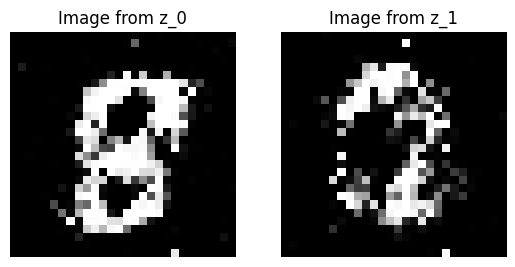

In [90]:
# first image
random_seed = 110 # change this seed to find the best image
torch.manual_seed(random_seed)
z_0 = torch.randn(1, z_dim, device=device) # FILL IN HERE
x_0 = gen_model(z_0) # FILL IN HERE

random_seed = 64 # change this seed to find the best image
torch.manual_seed(random_seed)
z_1 = torch.randn(1, z_dim, device=device) # FILL IN HERE
x_1 = gen_model(z_1) # FILL IN HERE

# display images
# FILL IN HERE
plt.subplot(1, 2, 1)
plt.imshow(x_0.squeeze().cpu().detach().numpy(), cmap='gray')
plt.title('Image from z_0')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_1.squeeze().cpu().detach().numpy(), cmap='gray')
plt.title('Image from z_1')
plt.axis('off')

plt.show()

Now, carry out the interpolation between these two points. You should __include__ the starting and ending codes $z_0$ and $z_1$. Display the results.

In [97]:
n_interpolation = 20

# FILL IN HERE
interpolation_weights = torch.linspace(0, 1, n_interpolation).unsqueeze(1).to(device)
interpolated_z = z_0 * (1 - interpolation_weights) + z_1 * interpolation_weights

# Generate images for interpolated latent vectors
interpolated_images = gen_model(interpolated_z)

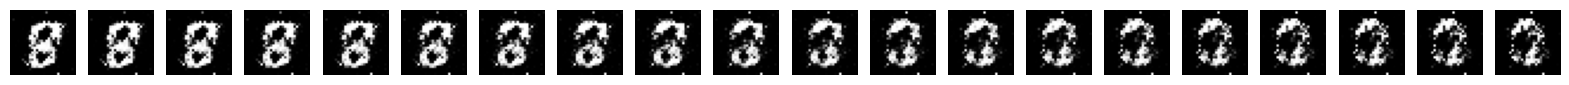

In [98]:
# display results

fig, axs = plt.subplots(1, n_interpolation,figsize=(20,20))
for i in range(n_interpolation):
  #black and white images
  axs[i].imshow( interpolated_images[i].squeeze().cpu().detach().numpy(), cmap='gray')  # FILL IN HERE
  axs[i].axis('off')
plt.show()

What do you think of the quality of the output images ?

In [ ]:
#We can clearly see the interpolation of the latent space between the two digits.

### Evaluation

Now, we are going to evaluate this navigation. We will investigate the following property:

- We are going to see whether by navigating between two points, the model produces images which are categorised in either of the classes (beginning class or end class), or if it traverses a region which is categorised in another class;

For this, we will first need a classification network. Use the following architecture :

- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

We also define a function ```get_accuracy``` to calculate the accuracy of our network.

In [110]:
# define mnist classifier model, loss function, optimiser and the function 'get_accuracy' (already done)

# BEGIN FILL IN HERE
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(288, 10)  # Assuming MNIST dataset with 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
# END FILL IN HERE

def get_accuracy(x_pred,x_label):
  acc = torch.sum(x_pred == x_label)/(x_pred.shape[0])
  return acc

In [111]:
# train the classifier

# FILL IN HERE
classifier_model = Classifier().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.001)

# Training loop
def train_classifier(model, criterion, optimizer, train_loader, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Train the classifier
train_classifier(classifier_model, criterion, optimizer, mnist_train_loader)

Epoch 1/5, Loss: 2.2532, Accuracy: 0.2220
Epoch 2/5, Loss: 2.0126, Accuracy: 0.4560
Epoch 3/5, Loss: 1.5247, Accuracy: 0.6630
Epoch 4/5, Loss: 0.9662, Accuracy: 0.7910
Epoch 5/5, Loss: 0.6483, Accuracy: 0.8370



Now, create a function which returns the classification returned by this network on mnist images. Remember, here we want the argmax, rather than the maximum probability. __Note__: the torch.max function returns a tuple: (max_values, max_indices).

In [112]:
def predict_mnist_class(imgs_in,classification_model):
  output_classes = classification_model(imgs_in) # FILL IN HERE
  return(output_classes)

Carry out and print the classification of your interpolated latent space images. What are your remarks ? Does the latent space navigation traverse regions with classes other than those of $z_0$ and $z_1$ ?

In [ ]:
z_classes = ... # FILL IN HERE
print(z_classes)

In [ ]:
#The response should be yes, we have traversed other classes.

# Training on CIFAR (optional)

If you want to try another, more challenging database, use the above code and modify it to carry out the GAN training on the CIFAR10 database. Note, it can take a long time to get good results

First, we download the data.

In [ ]:
# convert input to Pytorch tensors
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
print(cifar_trainset)

#create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0]
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=True)

n_rows = 32
n_cols = 32
n_channels = 3
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

Now, we can redefine the hyper-parameters of the model (change if you wish)

In [ ]:
## GAN parameters
z_dim = 10
batch_size = 64
n_epochs = 300
## parameters for training
n_iters_inner=1	#number of internal loops
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

For this case of CIFAR, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $8\times 8\times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size=$16 \times 16 \times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=3,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN.

Now, carry out the training (use code above)